## Introduction to Text Mining and NLP: Term Paper

---------------------------
Ramón Talvi

David Vallmanya

Irene Villalonga

---------------------------

In this term paper we will use Reddit's API to extract a huge number of users opinions in response to the prompt "Donald Trump has not made a single lasting positive impact on the USA during his term as president", which is included in a very popular reddit community called "Change my views". 

The project aims to analyze how the public, as represented by Reddit comments, perceive the performance of Trump's presidency in various political areas such as the economy, foreign affairs, COVID, gender, etc. The goal is to propose a logistic model that measures the relationship between a given political topic (for instance, gender) and the overall sentiment of the public on that specific topic: the idea is to measure Trump's perceived presidency performance on different political areas (topics). The model would use the topics as a covariates and the overall sentiment as the dependent variable.


### 1) WEB SCRAPING

In [165]:
import praw
import datetime
import pandas as pd
from praw.models import MoreComments

secret_token = ""
client_id = ""
username = ""
password = ""

reddit = praw.Reddit(client_id=client_id,
                     client_secret=secret_token, password=password,
                     user_agent='MyBot/0.0.1', username=username)

df = []

submission = reddit.submission(id='iq41dt')

submission.comment_sort = "best"
submission.comments.replace_more(limit=1500)

count_comments=0

for comment in submission.comments:

    if isinstance(comment, MoreComments):
        continue

    if comment.stickied == False:

        c_author = comment.author
        if c_author == None: 
            c_author = "NA"
        else:
            c_author = c_author.name

        c_replies = 0
        for reply in comment.replies:
            c_replies += 1

        c_awards = 0
        for award in comment.all_awardings:
            c_awards += 1

        df_comment = pd.DataFrame({
            'post_id': submission.id,
            'comment_id': comment.id,
            'subreddit': submission.subreddit.display_name,
            'post_title': submission.title,
            'post_ups': submission.ups,
            'post_upvote_ratio': submission.upvote_ratio,
            'post_num_comments': submission.num_comments,
            'post_time': datetime.datetime.fromtimestamp(submission.created_utc),
            'post_text': submission.selftext,
            'post_downs': submission.downs,
            'post_score': submission.score,
            'post_awards': p_awards,
            'comment_awards': c_awards,
            'comment_author': c_author,
            'body': comment.body,
            'comment_replies': c_replies,
            'comment_ups': comment.ups,
            'comment_downs': comment.downs,
            'comment_time' : datetime.datetime.fromtimestamp(comment.created_utc),
            'comment_score': comment.score
        }, index=[count_comments])

        df = pd.concat([df, df_comment])

        print("Post: "+str(count_posts) + "    Comment:"+ str(count_comments) + "    Inpost comment:" + str(i))

        count_comments += 1

df.to_csv("cmv_extract.csv", sep=';')
df.head()

ResponseException: received 401 HTTP response

### 2) PRE PROCESSING 
In this section we are going to first load and clean the Data Frame. Then we will carry out the usual steps in Text Mining preprocessing: tokenization, lemmatizing, remove punctuation, unify, remove stopwords, stemming. Finally we will obtain the Document Term Matrix. 

In [166]:
import os
import pandas as pd

In [274]:
# Load the dataframe
readin = '/Users/Ramon/Documents/Estudio/BSE/Term_2/Intro_Text_Analysis/Project/writingprompts-lda-project'
filename ="cmv_extract.csv"

df = pd.read_csv(os.path.join(readin, filename), sep=',', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       736 non-null    int64  
 1   Unnamed: 0         736 non-null    int64  
 2   post_id            736 non-null    object 
 3   comment_id         736 non-null    object 
 4   subreddit          736 non-null    object 
 5   post_title         736 non-null    object 
 6   post_ups           736 non-null    int64  
 7   post_upvote_ratio  736 non-null    float64
 8   post_num_comments  736 non-null    int64  
 9   post_time          736 non-null    object 
 10  post_text          736 non-null    object 
 11  post_downs         736 non-null    int64  
 12  post_score         736 non-null    int64  
 13  post_awards        736 non-null    int64  
 14  comment_awards     736 non-null    int64  
 15  comment_author     647 non-null    object 
 16  body               736 non

In [275]:
# Remove NA 
df = df.loc[df['body'] != '[removed]']
df = df.dropna(subset=['body']) 

df = df.reset_index(drop=True) 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       736 non-null    int64  
 1   Unnamed: 0         736 non-null    int64  
 2   post_id            736 non-null    object 
 3   comment_id         736 non-null    object 
 4   subreddit          736 non-null    object 
 5   post_title         736 non-null    object 
 6   post_ups           736 non-null    int64  
 7   post_upvote_ratio  736 non-null    float64
 8   post_num_comments  736 non-null    int64  
 9   post_time          736 non-null    object 
 10  post_text          736 non-null    object 
 11  post_downs         736 non-null    int64  
 12  post_score         736 non-null    int64  
 13  post_awards        736 non-null    int64  
 14  comment_awards     736 non-null    int64  
 15  comment_author     647 non-null    object 
 16  body               736 non

In [188]:
print("Post Title: \n", df.post_title[0])
print("   ")
print("Text 1 : \n", df.body[0])
print("   ")
print("Text 2 : \n", df.body[1])

Post Title: 
 CMV: Donald Trump has not made a single lasting positive impact on the USA during his term as president.
   
Text 1 : 
 How about his signing into law of "right-to-try" legislation, allowing gravely ill patients access to experimental drugs?
   
Text 2 : 
 I haven't seen this posted yet - but by far his most important accomplishment has been keeping America out of any new foreign conflicts. [According to this article](https://www.theelders.org/news/only-us-president-who-didnt-wage-war), the only other president who managed to keep the US out of new foreign conflicts was Jimmy Carter. Thus if this holds through the rest of his term, Trump will be only the second to manage that.

For all the talk about Trump being an idiot, and dangerous, and in over his head, I'd submit that keeping the US out of other people's wars is not an easy thing to do. I think he deserves an enormous amount of respect for having pulled this off.


Note that from a unique post title: " Donald Trump has not made a single lasting positive impact on the USA during his term as president" we have extracted 736 user's opinions. 

First, we are going to preprocess this texts and obtain the document term matrix.

In [189]:
import re
import nltk           

# Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

def remove_stopwords(text):
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)
        
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                if modulation==0:
                    stems.append(lowers)
                stems.append(" ")
    return "".join(stems)

In [248]:
# stop words
stop_words = set(stopwords.words('english')) 
my_stopwords = ['com', 'reddit', 'http', 'wiki', 'www', 'im', 'trump', 'lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make',
                'would', 'know', 'lot', 'see', 'president', 'done', 'even', 'many', 'ever', 'want', 'made',
                'got', 'going', 'need', 'view', 'something', 'lasting', 'still', 'way', 'every', 'anyone', 
                'first', 'look', 'medium', 'time', 'since', 'life', 'probably', 'anything', 'come', 
                'long', 'could', 'anything', 'donald', 'back', 'sure', 'last', 'nothing', 'rate', 'well',
                'left', 'le', 'someone', 'example', 'seen', 'day', 'said', 'world', 'making', 'far', 'care',
                'shit','america','issue','new', 'actually','never','whole','exposed','imapct','side','single']
stop_words.update(my_stopwords)

df['body'] = df['body'].apply(remove_stopwords)


# lemmatizing / stemming
mod=2 #=1 means stemming, =2 means lemmatizing, =0 just lowercase

text_preproc = (
    df.body
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

df_proc = df
df_proc["text_preproc"]=text_preproc


# again stopwords
df['text_preproc'] = df['text_preproc'].apply(remove_stopwords)


print("done with text")


100%|██████████| 736/736 [00:00<00:00, 1946.27it/s]

done with text


In [249]:
for article in df.text_preproc[:1]:
    print(article)

signing right try legislation allowing gravely ill patient access experimental drug


In [250]:
Texts = df_proc.text_preproc.tolist()

for text in Texts:
    remove_stopwords(text)

In [251]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Without tf-idf 
cv = CountVectorizer(ngram_range = (1,2))
cv.fit(Texts)
vectorized_text=cv.transform(Texts)
names=np.array(cv.get_feature_names())
print("dimensions of DT matrix are", vectorized_text.shape)

dimensions of DT matrix are (736, 21732)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [252]:
dtm = pd.DataFrame.sparse.from_spmatrix(vectorized_text)
dtm.head()

,0,1,2,3,4,5,6,7,8,9,...,21722,21723,21724,21725,21726,21727,21728,21729,21730,21731
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

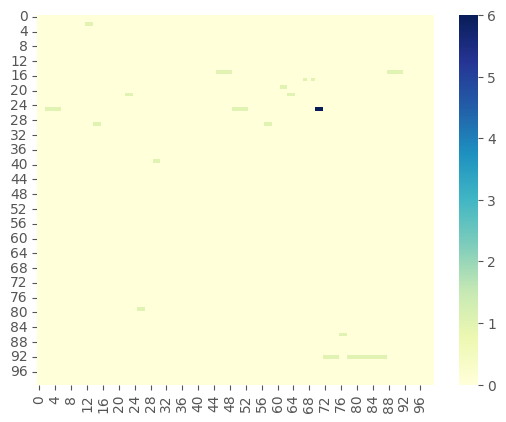

In [253]:
import seaborn as sns
import pandas as pd

# Heat matrix from Document Term Matrix
sns.heatmap(dtm.iloc[:100, :100], cmap='YlGnBu')

### 3) POST PROCESSING
In this section we are going to use both the term frequency and the inverse document frequency to reweight the terms in the document term matrix. 

In [311]:
# Try if tf-idf 

# from sklearn.feature_extraction.text import TfidfVectorizer

# cv = TfidfVectorizer(ngram_range = (1,2), norm=None)
# cv.fit(Texts)
# vectorized_text=cv.transform(Texts)
# vectorized_text=vectorized_text.todense()
# print("document term matrix has size", vectorized_text.shape)

### 4A) LDA IMPLEMENTATION 

In [254]:
len(Texts)

736

In [255]:
import nltk
nltk.download('punkt')

corp = [nltk.word_tokenize(text) for text in Texts]

[nltk_data] Downloading package punkt to /Users/Ramon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [256]:
import gensim
dictionary = gensim.corpora.Dictionary(corp)
len(dictionary)

5243

In [257]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [258]:
bow = [dictionary.doc2bow(line) for line in corp]

In [259]:
import matplotlib as plt

def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) 
              for t in range(ntopics) 
              for w,p in model.get_topic_terms(t, topn=1)]
              
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [262]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha=0.8, per_word_topics=True)
    # visuzlize the model term topics
    #viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=10)]))
    if print_dist:
        # display the topic probabilities for each document
        doc_topics_list = []
        for idx, (line,bag) in enumerate(zip(Texts,bow)):
            doc_topics = model.get_document_topics(bag)
            doc_topics_list.append({'document': idx, 'probabilities': dict(doc_topics)})
            print('{}: {}'.format(idx, doc_topics))
    return model, doc_topics_list




In [264]:
topic_proportions, doc_topics_list = test_eta('auto', dictionary, ntopics=7)
for doc_topics in doc_topics_list:
    print(doc_topics['document'], doc_topics['probabilities'])


Perplexity: -5.84
Topic 0: ['american', 'reform', 'trade', 'black', 'million', 'child', 'unemployment', 'administration', 'trafficking', 'accomplishment']
Topic 1: ['tax', 'signed', 'bill', 'order', 'federal', 'job', 'cut', 'price', 'drug', 'funding']
Topic 2: ['obama', 'policy', 'administration', 'korea', 'military', 'economy', 'news', 'real', 'state', 'best']
Topic 3: ['china', 'government', 'country', 'hate', 'though', 'vote', 'changed', 'fact', 'matter', 'person']
Topic 4: ['positive', 'right', 'impact', 'bad', 'presidency', 'country', 'pretty', 'political', 'believe', 'point']
Topic 5: ['war', 'peace', 'US', 'israel', 'troop', 'UAE', 'east', 'work', 'started', 'decade']
Topic 6: ['change', 'republican', 'system', 'great', 'politics', 'power', 'white', 'racist', 'take', 'court']
0: [(0, 0.1612537), (1, 0.41377103), (2, 0.06896945), (3, 0.0689699), (4, 0.14909546), (5, 0.06897023), (6, 0.068970256)]
1: [(0, 0.0842643), (1, 0.12957227), (2, 0.3833994), (3, 0.037040833), (4, 0.0370404

In [327]:
data = []
for i, doc_topics in enumerate(doc_topics_list):
    row = {'document': i}
    for topic, prob in doc_topics['probabilities'].items():
        row[f'topic_{topic+1}'] = prob
    data.append(row)

df_reg = pd.DataFrame(data)
print(df_reg)
len(df_reg)


     document   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0           0  0.161254  0.413771  0.068969  0.068970  0.149095  0.068970   
1           1  0.084264  0.129572  0.383399  0.037041  0.037040  0.291642   
2           2  0.061733  0.223010  0.102261  0.185361  0.181248  0.200927   
3           3  0.121216  0.121215  0.121216  0.121216  0.121216  0.272706   
4           4  0.241791  0.093676  0.125421  0.159517  0.145692  0.144707   
..        ...       ...       ...       ...       ...       ...       ...   
731       731  0.101722  0.022618  0.021910  0.224835  0.246536  0.021557   
732       732  0.037038  0.385585  0.043124  0.049740  0.112836  0.334658   
733       733  0.272725  0.121212  0.121212  0.121212  0.121212  0.121213   
734       734  0.121213  0.121213  0.121213  0.121213  0.121213  0.121213   
735       735  0.079019  0.075473  0.075473  0.075474  0.075473  0.079993   

      topic_7  
0    0.068970  
1    0.037041  
2    0.045459  
3    0.1212

736

In [280]:
# Visualize topic to see if assignation is consistent
for i in range(10):
    print(f"Document {i}: {df.body[i]}")
    topic_props = df_reg.iloc[i, 1:].tolist()
    print(f"Topic proportions: {topic_props}")




Document 0: How about his signing into law of "right-to-try" legislation, allowing gravely ill patients access to experimental drugs?
Topic proportions: [0.16125370562076569, 0.41377103328704834, 0.06896945089101791, 0.06896989792585373, 0.14909546077251434, 0.06897023320198059, 0.06897025555372238]
Document 1: I haven't seen this posted yet - but by far his most important accomplishment has been keeping America out of any new foreign conflicts. [According to this article](https://www.theelders.org/news/only-us-president-who-didnt-wage-war), the only other president who managed to keep the US out of new foreign conflicts was Jimmy Carter. Thus if this holds through the rest of his term, Trump will be only the second to manage that.

For all the talk about Trump being an idiot, and dangerous, and in over his head, I'd submit that keeping the US out of other people's wars is not an easy thing to do. I think he deserves an enormous amount of respect for having pulled this off.
Topic propo

NGRAMES: tax_cut, positive_change, human_trafficking,court_system

##### Try LDA using priors

In [208]:
# LDA using priors

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

apriori_original = {
    'war':0,'peace':0,'military':0,
    'tax':1,'cut':1,'business':1, 
    'economy':2, 'employment':2, 'growth':2, 'unemployment':2,
    'virus':3, 'pandemic':3, 'virus':3,'coronavirus':3,
    'media':4, 'news':4
}

eta = create_eta(apriori_original, dictionary, 5)
test_eta(eta, dictionary, 5)

Perplexity: -4.93
Topic 0: ['signed', 'bill', 'order', 'trade', 'federal', 'reform', 'price', 'million']
Topic 1: ['impact', 'country', 'bad', 'actually', 'shit', 'right', 'pretty', 'political']
Topic 2: ['tax', 'american', 'obama', 'administration', 'job', 'state', 'policy', 'cut']
Topic 3: ['war', 'china', 'peace', 'US', 'israel', 'korea', 'military', 'troop']
Topic 4: ['positive', 'america', 'change', 'republican', 'presidency', 'government', 'politics', 'power']
signing right try legislation allowing gravely ill patient access experimental drug ['(0, 54.5%)', '(1, 13.2%)', '(2, 9.1%)', '(3, 10.0%)', '(4, 13.2%)']
posted important accomplishment keeping america new foreign conflict according article theelders org news didnt wage war managed US new foreign conflict jimmy carter thus hold term second manage talk idiot dangerous submit keeping US war easy deserves enormous amount respect pulled ['(0, 4.6%)', '(1, 7.1%)', '(2, 35.0%)', '(3, 45.0%)', '(4, 8.4%)']
doubling standard deduct

### 4B) SENTIMENT ANALYSIS 

In [299]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# instructions
# pip install spacytextblob
# python3 -m textblob.download_corpora
# python3 -m spacy download en_core_web_sm
# pip install spacytextblob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

texts = df['text_preproc']
polarities = []
subjectivities = []

for text in texts:
    doc = nlp(text)
    polarity = doc._.blob.polarity
    polarities.append(polarity)
    subjectivity = doc._.blob.subjectivity
    subjectivities.append(subjectivity)

df['sentiment'] = polarities
df['subjectivity'] = subjectivities


In [300]:
len(subjectivities)

736

In [328]:
subjectivities_df = pd.DataFrame(subjectivities)
len(subjectivities_df)


for i in range(10,15):
    print(f"Document {i}: {df.body[i]}")
    subjectivities_ = subjectivities_df.iloc[i].tolist()
    print(f"Topic subjectivities: {subjectivities_}")


Document 10: Just want to say thank you for trying to start a meaningful discussion on this. I am a Canadian that follows politics, and I have tried very hard to be objective when it comes to Donald Trump. He doesn't make it easy sometimes but the people who worship him or burn an effigy of him make it far worse.
Topic subjectivities: [0.5958333333333333]
Document 11: The sole positive I see from him is that he did not turn a blind eye to China. His motivations may or may not have been off center, but the CCP is a tyrannical regime that deprives its people of basic liberty and human rights and they have been systematically destroying the economies of other countries by dumping goods at less than cost to both destroy local industry and get people addicted to artificially cheap goods. It’s the new opium. Not to mention the fentanyl they also export. That regime is every bit as deadly as Hitler’s Germany we just have not come to the realization. The world had been if the mindset of Chambe

### 5) LOGISTIC REGRESSION ANALYSIS

In [329]:
len(subjectivities_df)



736

In [336]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


# get the list of index labels to drop from df_reg
drop_index = df_reg[df_reg.isna().any(axis=1)].index.tolist()

# drop the same index labels from subjectivities
subjectivities_df.drop(drop_index, inplace=True)
df_reg.drop(drop_index, inplace=True)

# define y variable
X = df_reg.iloc[:, 1:].values
y = subjectivities_df.values

# fit logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()

# print model summary
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  729
Model:                            GLM   Df Residuals:                      722
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -361.53
Date:                Sun, 19 Feb 2023   Deviance:                       244.43
Time:                        22:20:04   Pearson chi2:                     194.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01880
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.7630      0.912     -1.934      0.0

array([[1.        , 0.16125371, 0.41377103, ..., 0.14909546, 0.06897023,
        0.06897026],
       [1.        , 0.0842643 , 0.12957227, ..., 0.03704049, 0.29164159,
        0.03704112],
       [1.        , 0.06173321, 0.22300971, ..., 0.18124831, 0.200927  ,
        0.0454594 ],
       ...,
       [1.        , 0.27272522, 0.12121237, ..., 0.12121245, 0.12121251,
        0.12121252],
       [1.        , 0.1212133 , 0.12121299, ..., 0.12121326, 0.12121346,
        0.27272034],
       [1.        , 0.0790191 , 0.07547305, ..., 0.07547345, 0.0799934 ,
        0.53909397]])

### 6) POSSIBLE EXTENSIONS 